# Machine Learning to prediect earthquakes

## Using XGBoost in SageMaker (Hyperparameter Tuning)

---

As an introduction to using SageMaker's High Level Python API for hyperparameter tuning, we will predict the shear stress in an earthquake cycle.

The documentation for the high level API can be found on the [ReadTheDocs page](http://sagemaker.readthedocs.io/en/latest/)

## General Outline

Typically, when using a notebook instance with SageMaker, you will proceed through the following steps.

1. Download or otherwise retrieve the data.
2. Process / Prepare the data.
3. Upload the processed data to S3.
4. Train a chosen model.
5. Test the trained model (typically using a batch transform job).
6. Deploy the trained model.
7. Use the deployed model.

## Step 0: Setting up the notebook

We begin by setting up all of the necessary bits required to run our notebook. To start that means loading all of the Python modules we will need.

In [1]:
%matplotlib inline

import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.datasets import load_boston
import sklearn.model_selection

In addition to the modules above, we need to import the various bits of SageMaker that we will be using. 

In [2]:
import sagemaker
from sagemaker import get_execution_role
from sagemaker.amazon.amazon_estimator import get_image_uri
from sagemaker.predictor import csv_serializer

# This is an object that represents the SageMaker session that we are currently operating in. This
# object contains some useful information that we will need to access later such as our region.
session = sagemaker.Session()

# This is an object that represents the IAM role that we are currently assigned. When we construct
# and launch the training job later we will need to tell it what IAM role it should have. Since our
# use case is relatively simple we will simply assign the training job the role we currently have.
role = get_execution_role()

## Step 1: Downloading the data

Fortunately, this dataset can be retrieved using sklearn and so this step is relatively straightforward.

In [3]:
input_data = np.loadtxt('trial1.csv', dtype=float, delimiter=',', skiprows=1) 

## Step 2: Preparing and splitting the data

Given that this is clean tabular data, we don't need to do any processing. However, we do need to split the rows in the dataset up into train, test and validation sets.

In [13]:
# First we package up the input data and the target variable (the median value) as pandas dataframes. This
# will make saving the data to a file a little easier later on.

feature_name = ['Time','Lat','Long','Depth','Magnitude','Injectivity']
data_pd = pd.DataFrame(input_data, columns = feature_name)
x_col = [0,1,2,3,4]
y_col = [5]
X_bos_pd = data_pd[data_pd.columns[x_col]]
Y_bos_pd = data_pd[data_pd.columns[y_col]]

# We split the dataset into 2/3 training and 1/3 testing sets.
X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(X_bos_pd, Y_bos_pd, test_size=24/274,shuffle=False)

# Then we split the training set further into 2/3 training and 1/3 validation sets.
X_train, X_val, Y_train, Y_val = sklearn.model_selection.train_test_split(X_train, Y_train, test_size=29/250,shuffle=False)

In [14]:
print(X_bos_pd)
print(Y_bos_pd)

        Time       Lat       Long  Depth  Magnitude
0     8711.0  43.72440 -121.30837 -1.215      0.063
1     9237.0  43.71980 -121.31587 -1.874      0.794
2     9372.0  43.72415 -121.31063 -1.300      0.336
3     9723.0  43.72507 -121.31078 -1.322      0.637
4    10041.0  43.72750 -121.30963 -1.223      0.105
..       ...       ...        ...    ...        ...
268  84439.0  43.72620 -121.31028 -0.893      0.150
269  84439.0  43.72682 -121.31138 -0.915      0.094
270  84461.0  43.72813 -121.30987 -0.300     -0.016
271  84546.0  43.72628 -121.30952 -1.092      0.330
272  84647.0  43.72645 -121.30965 -1.466      0.192

[273 rows x 5 columns]
     Injectivity
0       0.373712
1       0.326485
2       0.317715
3       0.345663
4       0.365866
..           ...
268     0.261664
269     0.261664
270     0.008599
271     0.219783
272     0.014036

[273 rows x 1 columns]


Text(0, 0.5, 'Injectivity')

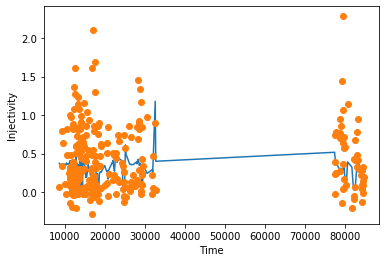

In [6]:
Time = data_pd[data_pd.columns[0]]
Magnitude = data_pd[data_pd.columns[4]]
Injectivity = data_pd[data_pd.columns[5]]
plt.plot(Time,Injectivity)
plt.plot(Time,Magnitude,'o')
plt.xlabel("Time")
plt.ylabel("Injectivity")

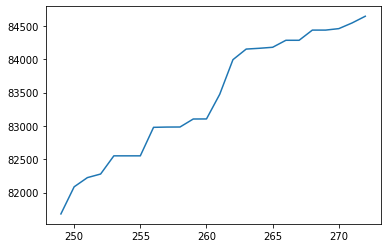

In [15]:
plt.plot(X_test.Time)


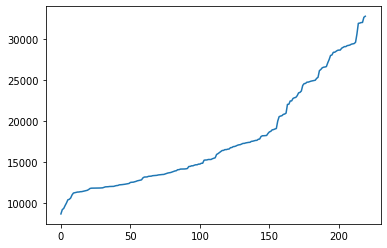

In [16]:
plt.plot(X_train.Time)

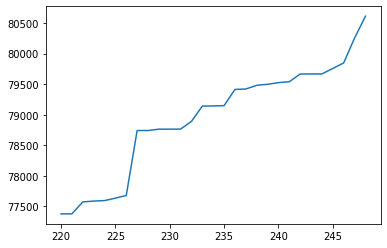

In [17]:
plt.plot(X_val.Time)

## Step 3: Uploading the data files to S3

When a training job is constructed using SageMaker, a container is executed which performs the training operation. This container is given access to data that is stored in S3. This means that we need to upload the data we want to use for training to S3. In addition, when we perform a batch transform job, SageMaker expects the input data to be stored on S3. We can use the SageMaker API to do this and hide some of the details.

### Save the data locally

First we need to create the test, train and validation csv files which we will then upload to S3.

In [18]:
# This is our local data directory. We need to make sure that it exists.
data_dir = '../data/MLtrail1/HyperparameterTuning'
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

In [19]:
# We use pandas to save our test, train and validation data to csv files. Note that we make sure not to include header
# information or an index as this is required by the built in algorithms provided by Amazon. Also, for the train and
# validation data, it is assumed that the first entry in each row is the target variable.

X_test.to_csv(os.path.join(data_dir, 'test.csv'), header=False, index=False)

pd.concat([Y_val, X_val], axis=1).to_csv(os.path.join(data_dir, 'validation.csv'), header=False, index=False)
pd.concat([Y_train, X_train], axis=1).to_csv(os.path.join(data_dir, 'train.csv'), header=False, index=False)

### Upload to S3

Since we are currently running inside of a SageMaker session, we can use the object which represents this session to upload our data to the 'default' S3 bucket. Note that it is good practice to provide a custom prefix (essentially an S3 folder) to make sure that you don't accidentally interfere with data uploaded from some other notebook or project.

In [20]:
prefix = 'MLtrail1HyperparameterTuning'

test_location = session.upload_data(os.path.join(data_dir, 'test.csv'), key_prefix=prefix)
val_location = session.upload_data(os.path.join(data_dir, 'validation.csv'), key_prefix=prefix)
train_location = session.upload_data(os.path.join(data_dir, 'train.csv'), key_prefix=prefix)

## Step 4: Train the XGBoost model

Now that we have the training and validation data uploaded to S3, we can construct our XGBoost model and train it. Unlike in the previous notebooks, instead of training a single model, we will use SageMaker's hyperparameter tuning functionality to train multiple models and use the one that performs the best on the validation set.

To begin with, as in the previous approaches, we will need to construct an estimator object.

In [21]:
# As stated above, we use this utility method to construct the image name for the training container.
container = get_image_uri(session.boto_region_name, 'xgboost', '1.0-1')

# Now that we know which container to use, we can construct the estimator object.
xgb = sagemaker.estimator.Estimator(container, # The name of the training container
                                    role,      # The IAM role to use (our current role in this case)
                                    train_instance_count=1, # The number of instances to use for training
                                    train_instance_type='ml.m4.xlarge', # The type of instance ot use for training
                                    output_path='s3://{}/{}/output'.format(session.default_bucket(), prefix),
                                                                        # Where to save the output (the model artifacts)
                                    sagemaker_session=session) # The current SageMaker session

'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.
Parameter image_name will be renamed to image_uri in SageMaker Python SDK v2.


Before beginning the hyperparameter tuning, we should make sure to set any model specific hyperparameters that we wish to have default values. There are quite a few that can be set when using the XGBoost algorithm, below are just a few of them. If you would like to change the hyperparameters below or modify additional ones you can find additional information on the [XGBoost hyperparameter page](https://docs.aws.amazon.com/sagemaker/latest/dg/xgboost_hyperparameters.html)

In [22]:
xgb.set_hyperparameters(max_depth=5,
                        eta=0.2,
                        gamma=4,
                        min_child_weight=6,
                        subsample=0.8,
                        objective='reg:linear',
                        early_stopping_rounds=10,
                        num_round=200)

Now that we have our estimator object completely set up, it is time to create the hyperparameter tuner. To do this we need to construct a new object which contains each of the parameters we want SageMaker to tune. In this case, we wish to find the best values for the `max_depth`, `eta`, `min_child_weight`, `subsample`, and `gamma` parameters. Note that for each parameter that we want SageMaker to tune we need to specify both the *type* of the parameter and the *range* of values that parameter may take on.

In addition, we specify the *number* of models to construct (`max_jobs`) and the number of those that can be trained in parallel (`max_parallel_jobs`). In the cell below we have chosen to train `20` models, of which we ask that SageMaker train `3` at a time in parallel. Note that this results in a total of `20` training jobs being executed which can take some time, in this case almost a half hour. With more complicated models this can take even longer so be aware!

In [23]:
from sagemaker.tuner import IntegerParameter, ContinuousParameter, HyperparameterTuner

xgb_hyperparameter_tuner = HyperparameterTuner(estimator = xgb, # The estimator object to use as the basis for the training jobs.
                                               objective_metric_name = 'validation:rmse', # The metric used to compare trained models.
                                               objective_type = 'Minimize', # Whether we wish to minimize or maximize the metric.
                                               max_jobs = 20, # The total number of models to train
                                               max_parallel_jobs = 3, # The number of models to train in parallel
                                               hyperparameter_ranges = {
                                                    'max_depth': IntegerParameter(2, 20),
                                                    'eta'      : ContinuousParameter(0.05, 0.5),
                                                    'min_child_weight': IntegerParameter(2, 8),
                                                    'subsample': ContinuousParameter(0.5, 0.9),
                                                    'gamma': ContinuousParameter(0, 10),
                                               })

Now that we have our hyperparameter tuner object completely set up, it is time to train it. To do this we make sure that SageMaker knows our input data is in csv format and then execute the `fit` method.

In [24]:
# This is a wrapper around the location of our train and validation data, to make sure that SageMaker
# knows our data is in csv format.
s3_input_train = sagemaker.s3_input(s3_data=train_location, content_type='csv')
s3_input_validation = sagemaker.s3_input(s3_data=val_location, content_type='csv')

xgb_hyperparameter_tuner.fit({'train': s3_input_train, 'validation': s3_input_validation})

's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.


As in many of the examples we have seen so far, the `fit()` method takes care of setting up and fitting a number of different models, each with different hyperparameters. If we wish to wait for this process to finish, we can call the `wait()` method.

In [25]:
xgb_hyperparameter_tuner.wait()

.....................................................................................................................................................................................................................................................................................................!


Once the hyperamater tuner has finished, we can retrieve information about the best performing model. 

In [26]:
xgb_hyperparameter_tuner.best_training_job()

'sagemaker-xgboost-200814-1336-013-0953e145'

In addition, since we'd like to set up a batch transform job to test the best model, we can construct a new estimator object from the results of the best training job. The `xgb_attached` object below can now be used as though we constructed an estimator with the best performing hyperparameters and then fit it to our training data.

In [27]:
xgb_attached = sagemaker.estimator.Estimator.attach(xgb_hyperparameter_tuner.best_training_job())

Parameter image_name will be renamed to image_uri in SageMaker Python SDK v2.


2020-08-14 13:53:48 Starting - Preparing the instances for training
2020-08-14 13:53:48 Downloading - Downloading input data
2020-08-14 13:53:48 Training - Training image download completed. Training in progress.
2020-08-14 13:53:48 Uploading - Uploading generated training model
2020-08-14 13:53:48 Completed - Training job completedINFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:Failed to parse hyperparameter _tuning_objective_metric value validation:rmse to Json.
Returning the value itself
INFO:sagemaker-containers:Failed to parse hyperparameter objective value reg:linear to Json.
Returning the value itself
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Running XGBoost Sagemaker in algorithm mode
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
[13:53:38] 2

## Step 5: Test the model

Now that we have our best performing model, we can test it. To do this we will use the batch transform functionality. To start with, we need to build a transformer object from our fit model.

In [28]:
xgb_transformer = xgb_attached.transformer(instance_count = 1, instance_type = 'ml.m4.xlarge')

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.


Next we ask SageMaker to begin a batch transform job using our trained model and applying it to the test data we previous stored in S3. We need to make sure to provide SageMaker with the type of data that we are providing to our model, in our case `text/csv`, so that it knows how to serialize our data. In addition, we need to make sure to let SageMaker know how to split our data up into chunks if the entire data set happens to be too large to send to our model all at once.

Note that when we ask SageMaker to do this it will execute the batch transform job in the background. Since we need to wait for the results of this job before we can continue, we use the `wait()` method. An added benefit of this is that we get some output from our batch transform job which lets us know if anything went wrong.

In [29]:
xgb_transformer.transform(test_location, content_type='text/csv', split_type='Line')

In [30]:
xgb_transformer.wait()

............................2020-08-14T14:05:22.698:[sagemaker logs]: MaxConcurrentTransforms=4, MaxPayloadInMB=6, BatchStrategy=MULTI_RECORD
[2020-08-14:14:05:20:INFO] No GPUs detected (normal if no gpus installed)
[2020-08-14:14:05:20:INFO] No GPUs detected (normal if no gpus installed)
[2020-08-14:14:05:20:INFO] nginx config: 
worker_processes auto;
daemon off;
pid /tmp/nginx.pid;
error_log  /dev/stderr;

worker_rlimit_nofile 4096;

events {
  worker_connections 2048;
}

[2020-08-14:14:05:20:INFO] No GPUs detected (normal if no gpus installed)
[2020-08-14:14:05:20:INFO] No GPUs detected (normal if no gpus installed)
[2020-08-14:14:05:20:INFO] nginx config: 
worker_processes auto;
daemon off;
pid /tmp/nginx.pid;
error_log  /dev/stderr;

worker_rlimit_nofile 4096;

events {
  worker_connections 2048;
}

http {
  include /etc/nginx/mime.types;
  default_type application/octet-stream;
  access_log /dev/stdout combined;

  upstream gunicorn {
    server unix:/tmp/gunicorn.sock;
  }

  se

Now that the batch transform job has finished, the resulting output is stored on S3. Since we wish to analyze the output inside of our notebook we can use a bit of notebook magic to copy the output file from its S3 location and save it locally.

In [31]:
!aws s3 cp --recursive $xgb_transformer.output_path $data_dir

download: s3://sagemaker-us-east-2-591732259735/sagemaker-xgboost-200814-1336-013-0953e-2020-08-14-14-00-50-330/test.csv.out to ../data/MLtrail1/HyperparameterTuning/test.csv.out


To see how well our model works we can create a simple scatter plot between the predicted and actual values. If the model was completely accurate the resulting scatter plot would look like the line $x=y$. As we can see, our model seems to have done okay but there is room for improvement.

In [32]:
Y_pred = pd.read_csv(os.path.join(data_dir, 'test.csv.out'), header=None)

Text(0, 0.5, 'Injectivity,L/s/MPa')

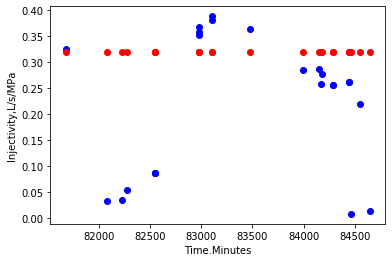

In [33]:
plt.plot(X_test.Time,Y_test,'o',c="b")
plt.plot(X_test.Time,Y_pred,'o',c="r")
plt.xlabel("Time.Minutes")
plt.ylabel("Injectivity,L/s/MPa")


Text(0, 0.5, 'Shear Stress,MPa')

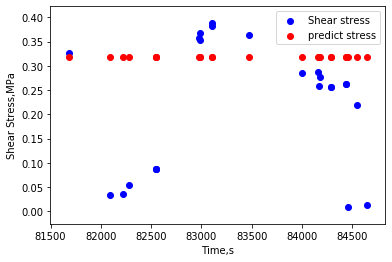

In [34]:
a1=plt.scatter(X_test.Time,Y_test,c="b")
a2=plt.scatter(X_test.Time,Y_pred,c="r")
plt.legend((a1,a2),('Shear stress','predict stress'))
plt.xlabel("Time,s")
plt.ylabel("Shear Stress,MPa")

Text(0, 0.5, 'Shear Stress,MPa')

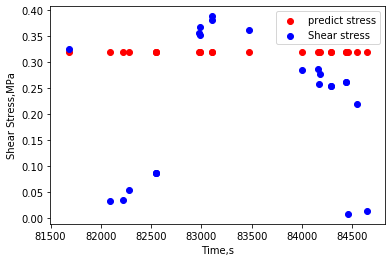

In [35]:
a1=plt.scatter(X_test.Time,Y_pred,c="r")
a2=plt.scatter(X_test.Time,Y_test,c="b")

plt.legend((a1,a2),('predict stress','Shear stress'))
plt.xlabel("Time,s")
plt.ylabel("Shear Stress,MPa")

## Optional: Clean up

The default notebook instance on SageMaker doesn't have a lot of excess disk space available. As you continue to complete and execute notebooks you will eventually fill up this disk space, leading to errors which can be difficult to diagnose. Once you are completely finished using a notebook it is a good idea to remove the files that you created along the way. Of course, you can do this from the terminal or from the notebook hub if you would like. The cell below contains some commands to clean up the created files from within the notebook.

In [ ]:
# First we will remove all of the files contained in the data_dir directory
!rm $data_dir/*

# And then we delete the directory itself
!rmdir $data_dir